# Lab3. Build your CNN script with Tensorflow

In this lab, you will develop your own Tensorflow-based Keras CNN script to recognize charactors from cropped license plate.  

## Set up your local environment

* **Plase note that the Tensorflow eager mode will be enabled by below code:**  
 tf.enable_eager_execution()

In [1]:
import numpy as np
from keras import layers


# from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
# from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
# from keras.models import Model
# from keras.preprocessing import image
# from keras.utils import layer_utils
# from keras.utils.data_utils import get_file
# from keras.applications.imagenet_utils import preprocess_input
# # import pydot
# # from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
# from keras.utils import plot_model
# # from kt_utils import *
# from keras.layers import concatenate


import os
import argparse

import json
from PIL import Image
# from PIL import ImageDraw
# from PIL import ImageFont

# import keras.backend as K
# K.set_image_data_format('channels_last')
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import imshow
import tensorflow as tf

from tensorflow.contrib.eager.python import tfe

tf.enable_eager_execution()

Using TensorFlow backend.


* Load the number charactor definition list 

In [3]:
NUMS =['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']
CHARS=['가', '나', '다', '라', '마', '거', '너', '더', '러', '머', '고', '노', '도', '로', '모', '구', '누', '두', '루', '무', 
       '버', '서', '어', '저', '처', '커', '터', '퍼', '보', '소', '오', '조', '초', '코', '토', '포', '부', '수', '우', '주', '추', '쿠', '투', '푸', '후', 
       '그', '느', '드', '르', '므', '브', '스', '으', '즈', '츠', '크', '트', '프', '흐',
       '바', '사', '아', '자', '차', '카', '타', '파', '하', '허', '호']
SPACE=[' ']
JOIN =NUMS + CHARS + SPACE
n_chr = len(JOIN)

## Divide train and valdiation data from cropped images

* We will use cropped-imgs and nums-tags which we generated at Lab1

In [4]:
jsons = os.listdir('gen/nums-tags')
print ('There are {:,} images have annotation files.'.format(len(jsons)))
print ('There are {:,} image files.'.format(len(os.listdir('gen/cropped-imgs'))))

There are 5,000 images have annotation files.
There are 5,000 image files.


* prepare folder to store divided train/validation data

In [5]:
!rm -fR tf
!mkdir tf tf/tf-train tf/tf-train_annotation tf/tf-validation tf/tf-validation_annotation

* Define the number of train/valdiation images

In [6]:
n_samples = len(os.listdir('gen/cropped-imgs'))
n_val = 5000 if n_samples > 25000 else round(n_samples * 0.2)
n_train = n_samples - n_val
print('{:,} images will be used for training, and {:,} images will be used for validation.'.format(n_train, n_val))

4,000 images will be used for training, and 1,000 images will be used for validation.


* Move images and annotation files to tf-train and tf-validation folders  

In [7]:
import shutil

train_jsons = jsons[:n_train]
val_jsons = jsons[n_train:]

#Moving training files to the training folders
for i in train_jsons:
    image_file = './gen/cropped-imgs/'+i.split('.')[0]+'.png'
    shutil.move(image_file, './tf/tf-train/')
    shutil.move('./gen/nums-tags/'+i, './tf/tf-train_annotation/')

#Moving validation files to the validation folders
for i in val_jsons:
    image_file = './gen/cropped-imgs/'+i.split('.')[0]+'.png'
    shutil.move(image_file, './tf/tf-validation/')
    shutil.move('./gen/nums-tags/'+i, './tf/tf-validation_annotation/')

* check the move result

In [8]:
print('there are {:,} files in gen/cropped-imgs folder.'.format(len(os.listdir('gen/cropped-imgs'))))
print('there are {:,} files in gen/nums-tags folder.'.format(len(os.listdir('gen/nums-tags'))))
print('there are {:,} files in tf/tf-train folder.'.format(len(os.listdir('tf/tf-train'))))
print('there are {:,} files in tf/tf-train_annotation folder.'.format(len(os.listdir('tf/tf-train_annotation'))))
print('there are {:,} files in tf/tf-validation folder.'.format(len(os.listdir('tf/tf-validation'))))
print('there are {:,} files in tf/tf-validation_annotation folder.'.format(len(os.listdir('tf/tf-validation_annotation'))))

there are 0 files in gen/cropped-imgs folder.
there are 0 files in gen/nums-tags folder.
there are 4,000 files in tf/tf-train folder.
there are 4,000 files in tf/tf-train_annotation folder.
there are 1,000 files in tf/tf-validation folder.
there are 1,000 files in tf/tf-validation_annotation folder.


## Load data(images/annotations) for local training

* Define a function to read the pair of cropped image and annotation
* Image will be resized to 128 x 64
* Annotation t_annotations and v_annotations are lists of 7 np array representing digit of each 7 positions

In [9]:
def get_data_pair(train_dir, annotation_dir):
    t_jsns = os.listdir(annotation_dir)
    flg_first = True
    for i in t_jsns:
        ext = i.split('.')[1]
        if ext == 'json':
            with open(annotation_dir + i, "r") as jfile:
                jdata = json.load(jfile)
                # read image
                img=Image.open(train_dir + jdata['file']) 
                img = img.resize((128, 64))
                imgs = img if flg_first else np.append(imgs, img)
                # read license plate numbers
                n_ = np.array(jdata['nums'])
                Y_t = np.zeros((n_chr, 7))
                Y_t[n_, np.arange(7)] = 1
                Y_ = Y_t if (flg_first) else np.append(Y_, Y_t)
                flg_first = False
    Y_= np.split(Y_.reshape([-1,7]), 7, axis=1)
    return imgs.reshape([-1, 128, 64, 1])/255., [i.reshape([-1,81]) for i in Y_]

In [10]:
t_imgs, t_annotations = get_data_pair('tf/tf-train/', 'tf/tf-train_annotation/')
v_imgs, v_annotations = get_data_pair('tf/tf-validation/', 'tf/tf-validation_annotation/')

In [27]:
print('{:,} train images and {:,} annotations were loaded.'.format(len(t_imgs),len(t_annotations[0])))
print('{:,} validation images and {:,} annotations were loaded.'.format(len(v_imgs),len(v_annotations[0])))

4,000 train images and 4,000 annotations were loaded.
1,000 validation images and 1,000 annotations were loaded.


In [22]:
print("annotation files are composed of {} numpy arrays".format(len(t_annotations)))
print("1st array's shape is {}".format(t_annotations[0].shape))
print("2nd array's shape is {}".format(t_annotations[1].shape))
print("...")
print("7th array's shape is {}".format(t_annotations[6].shape))

annotation files are composed of 7 numpy arrays
1st array's shape is (4000, 81)
2nd array's shape is (4000, 81)
...
7th array's shape is (4000, 81)


* Check 3 sample pairs of training data

In [25]:
import matplotlib.pyplot as plt

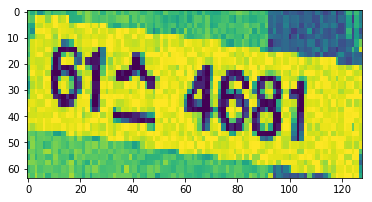

['6', '1', '스', '4', '6', '8', '1']


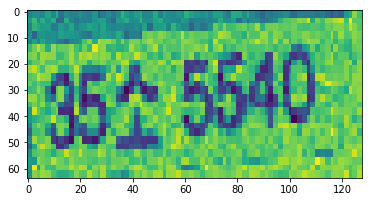

['3', '5', '소', '5', '5', '4', '0']


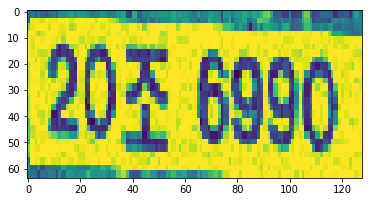

['2', '0', '조', '6', '9', '9', '0']


In [26]:
for i in range(3):
    plt.imshow(t_imgs[i].reshape([64,128]))
    plt.show()
    digits = [JOIN[np.argmax(t_annotations[0][i])], 
              JOIN[np.argmax(t_annotations[1][i])], 
              JOIN[np.argmax(t_annotations[2][i])], 
              JOIN[np.argmax(t_annotations[3][i])], 
              JOIN[np.argmax(t_annotations[4][i])], 
              JOIN[np.argmax(t_annotations[5][i])], 
              JOIN[np.argmax(t_annotations[6][i])]]
    print(digits)

## Define CNN model
* Define 3 Convolutions layers with Batch Normalization and Max Pooling
* Will have 7 output nodes representing license plate charactor at each position

In [28]:
def model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = tf.keras.Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = tf.keras.layers.ZeroPadding2D((2, 2))(X_input)

    # CONV0 -> BN -> RELU -> MAXPOOL applied to X
    X = tf.keras.layers.Conv2D(48, (5, 5), strides = (1, 1), name = 'conv0')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn0')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2), name='max_pool0')(X)

    # CONV1 -> BN -> RELU -> MAXPOOL applied to X
    X = tf.keras.layers.Conv2D(64, (5, 5), strides = (1, 1), name = 'conv1')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn1')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((1, 2), strides = (2, 2), name='max_pool1')(X)

    # CONV2 -> BN -> RELU -> MAXPOOL applied to X
    X = tf.keras.layers.Conv2D(64, (5, 5), strides = (1, 1), name = 'conv2')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn2')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2), name='max_pool2')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = tf.keras.layers.Flatten()(X)
#     X = tf.keras.layers.Dense(7, activation='softmax', name='fc')(X)

    #----------------------------------------------------------
    d1 = tf.keras.layers.Dense(81, activation='softmax', name='d1')(X)
    d2 = tf.keras.layers.Dense(81, activation='softmax', name='d2')(X)
    d3 = tf.keras.layers.Dense(81, activation='softmax', name='d3')(X)
    d4 = tf.keras.layers.Dense(81, activation='softmax', name='d4')(X)
    d5 = tf.keras.layers.Dense(81, activation='softmax', name='d5')(X)
    d6 = tf.keras.layers.Dense(81, activation='softmax', name='d6')(X)
    d7 = tf.keras.layers.Dense(81, activation='softmax', name='d7')(X)
    
    model = tf.keras.Model(inputs = X_input, 
                  outputs = [d1,d2,d3,d4,d5,d6,d7],
                  name='CNN_ANPR')

    return model

* Compile the model and veiw summary

In [29]:
input_shape = (128,64,1)
model_k = model(input_shape)
model_k.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
                loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy',
                      'categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'],
                metrics = ["accuracy"])
model_k.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 64, 1)   0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 132, 68, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 64, 48)  1248        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn0 (BatchNormalization)        (None, 128, 64, 48)  192         conv0[0][0]                      
__________________________________________________________________________________________________
activation

* Finally, run traing job
* **It may take 10~20 minutes**
* For now, We wll just run 5 epochs to see if our code works well
* **Do check the loss is decresing and the accuracy is increasing from training job logs**

In [30]:
%%time
model_k.fit(t_imgs, [i.reshape([-1,81]) for i in t_annotations], 
            validation_data=(v_imgs, [i.reshape([-1,81]) for i in v_annotations]), 
            epochs=5, batch_size=128, verbose=1)

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 122s 30ms/step - loss: 20.5120 - d1_loss: 2.6170 - d2_loss: 2.5812 - d3_loss: 5.0121 - d4_loss: 2.5724 - d5_loss: 2.5592 - d6_loss: 2.5636 - d7_loss: 2.6064 - d1_acc: 0.1032 - d2_acc: 0.1087 - d3_acc: 0.0180 - d4_acc: 0.0953 - d5_acc: 0.1082 - d6_acc: 0.1120 - d7_acc: 0.1030 - val_loss: 18.5341 - val_d1_loss: 2.3260 - val_d2_loss: 2.3788 - val_d3_loss: 4.4170 - val_d4_loss: 2.3374 - val_d5_loss: 2.3830 - val_d6_loss: 2.3735 - val_d7_loss: 2.3183 - val_d1_acc: 0.0910 - val_d2_acc: 0.0980 - val_d3_acc: 0.0110 - val_d4_acc: 0.1190 - val_d5_acc: 0.1110 - val_d6_acc: 0.0980 - val_d7_acc: 0.1060
Epoch 2/10
4000/4000 [==============================] - 118s 30ms/step - loss: 18.5858 - d1_loss: 2.3636 - d2_loss: 2.3440 - d3_loss: 4.4452 - d4_loss: 2.3645 - d5_loss: 2.3434 - d6_loss: 2.3588 - d7_loss: 2.3664 - d1_acc: 0.1313 - d2_acc: 0.1373 - d3_acc: 0.0280 - d4_acc: 0.1235 - d5_acc: 0.1343 -

## Evaluate model

* Check the overall accuracy

In [32]:
### START CODE HERE ### (1 line)
preds = model_k.evaluate(v_imgs, [i.reshape([-1,81]) for i in v_annotations], batch_size=32, verbose=1, sample_weight=None)
### END CODE HERE ###
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

1000/1000 [==============================] - 7s 7ms/step

Loss = 15.560110679626465
Test Accuracy = 1.7879132690429687


* Check the prediction resutls with 10 sample data pairs

In [33]:
prediction = model_k.predict(v_imgs[:10])

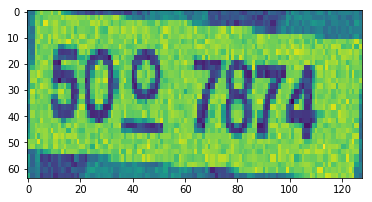

['5', '7', '느', '1', '1', '1', '1']


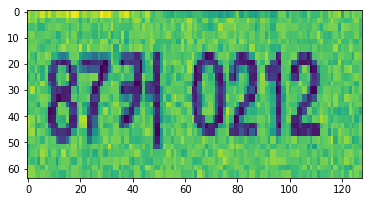

['6', '7', '느', '1', '3', '1', '7']


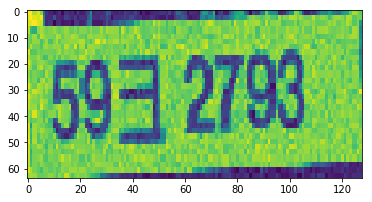

['7', '4', '느', '2', '7', '1', '1']


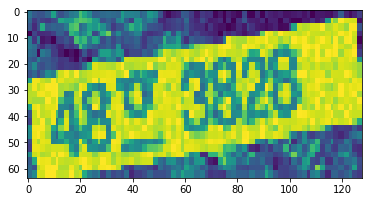

['7', '7', '느', '3', '6', '2', '1']


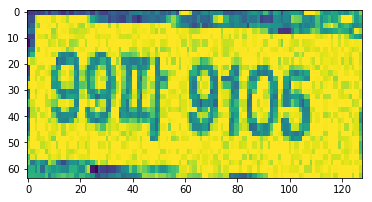

['7', '7', '느', '4', '1', '1', '7']


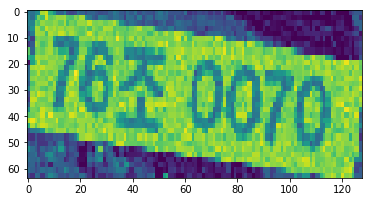

['7', '7', '느', '1', '1', '1', '1']


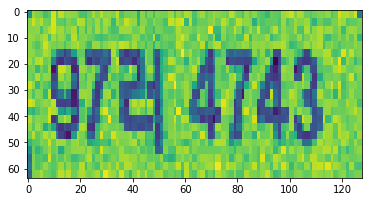

['2', '7', '느', '4', '0', '1', '2']


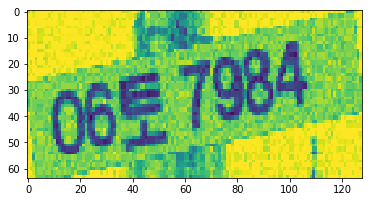

['0', '7', '느', '7', '1', '2', '1']


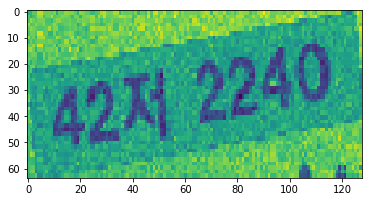

['2', '7', '느', '1', '1', '2', '1']


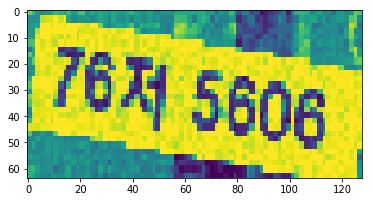

['7', '5', '으', '5', '1', '2', '1']


In [34]:
for i in range(10):
    plt.imshow(v_imgs[i].reshape([64,128]))
    plt.show()
    digits = [JOIN[np.argmax(prediction[0][i])], 
              JOIN[np.argmax(prediction[1][i])], 
              JOIN[np.argmax(prediction[2][i])], 
              JOIN[np.argmax(prediction[3][i])], 
              JOIN[np.argmax(prediction[4][i])], 
              JOIN[np.argmax(prediction[5][i])], 
              JOIN[np.argmax(prediction[6][i])]]
    print(digits)

* We verified our code runs successfully
* The accuracy of our model is not good enough yet
* **We will retrain our model with SageMaker in Lab4**